In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

from random import seed
from random import random
from sklearn.linear_model import LogisticRegression

import importlib
import SOAMtg24_models as mdls
importlib.reload(mdls)


<module 'SOAMtg24_models' from '/Users/joehaber/Desktop/Desktop/1. ActuariAI/Research/OWL_Nadav/SOAMtg24_models.py'>

### Get Data

In [2]:
df = pd.read_csv('Readmit_R.csv')

In [3]:
# Clean up

df.drop(columns=df.columns[0:1], axis=1, inplace=True)

df.rename({'ID.Codes': 'ID', 
           'Readmission.Status': 'Readmit', 
           'DRG.Class': 'DRG_Class', 
           'DRG.Complication': 'DRG_Comp',
           'HCC.Riskscore': 'HCC'}, axis=1, inplace=True)

In [4]:
print(df.shape)
df.head()

(66782, 10)


ID  Readmit Gender   Race  ER DRG_Class  LOS  Age    HCC  \
0  0005EC02F1DC3A15        0      M  White   0       MED    3   71  1.631   
1  0005EC02F1DC3A15        0      M  White   0      SURG    2   71  1.631   
2  0006C4369B0D7B5F        0      M  White   0       MED    2   68  0.585   
3  000960C9E1C43BE4        0      F  White   0      SURG   12   79  1.660   
4  00098CF15837D918        0      M  White   0      SURG    4   91  1.768   

        DRG_Comp  
0  MedicalMCC.CC  
1          Other  
2     MedicalNoC  
3        SurgNoC  
4        SurgNoC

In [5]:
df.Readmit.value_counts()

Readmit
0    58373
1     8409
Name: count, dtype: int64

In [6]:
df1 = pd.get_dummies(df, columns = ['Gender','Race','DRG_Class','DRG_Comp'], drop_first=True)

In [7]:
df1.head()

ID  Readmit  ER  LOS  Age    HCC  Gender_M  Race_Hispanic  \
0  0005EC02F1DC3A15        0   0    3   71  1.631      True          False   
1  0005EC02F1DC3A15        0   0    2   71  1.631      True          False   
2  0006C4369B0D7B5F        0   0    2   68  0.585      True          False   
3  000960C9E1C43BE4        0   0   12   79  1.660     False          False   
4  00098CF15837D918        0   0    4   91  1.768      True          False   

   Race_Others  Race_White  DRG_Class_SURG  DRG_Class_UNGROUP  \
0        False        True           False              False   
1        False        True            True              False   
2        False        True           False              False   
3        False        True            True              False   
4        False        True            True              False   

   DRG_Comp_MedicalNoC  DRG_Comp_Other  DRG_Comp_SurgMCC.CC  DRG_Comp_SurgNoC  
0                False           False                False             False  
1                False            True                False             False  
2                 True           False                False             False  
3                False           False                False              True  
4                False           False                False              True

### Create Subgroups (via risk propensities)

In [8]:
df1 = mdls.create_subgroups(df1)

In [9]:
df1.groupby('subgroup')['preds'].mean()

subgroup
0    0.071706
1    0.130614
2    0.283908
Name: preds, dtype: float64

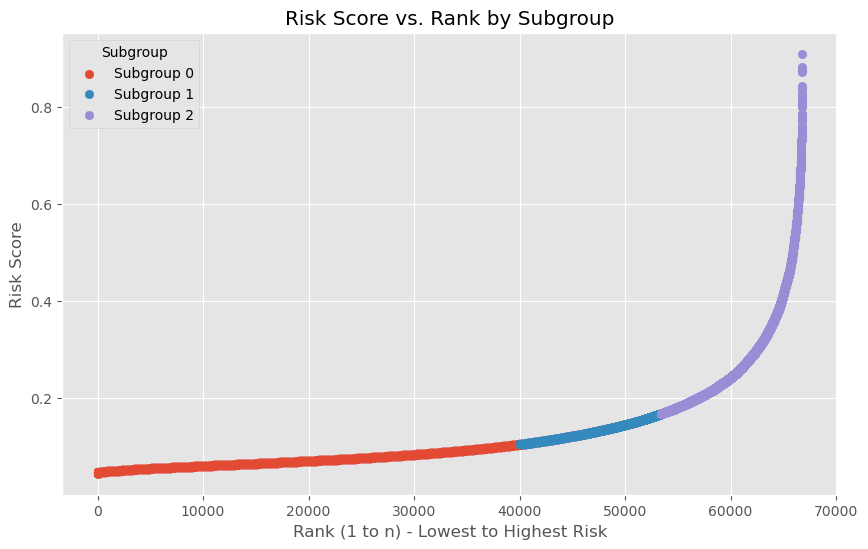

In [10]:
# Sort the DataFrame by 'preds' to get the ranks
df_sorted = df1.sort_values(by='preds').reset_index(drop=True)

# Create a rank for x-axis
df_sorted['rank'] = df_sorted.index + 1

# Plotting
plt.figure(figsize=(10, 6))

# Loop through each unique subgroup and plot with a different color
for subgroup in df_sorted['subgroup'].unique():
    subgroup_data = df_sorted[df_sorted['subgroup'] == subgroup]
    plt.scatter(subgroup_data['rank'], subgroup_data['preds'], label=f'Subgroup {subgroup}')

plt.xlabel('Rank (1 to n) - Lowest to Highest Risk')
plt.ylabel('Risk Score')
plt.title('Risk Score vs. Rank by Subgroup')
plt.grid(True)
plt.legend(title='Subgroup')
plt.show()

### Create Treatment (Impact)

In [11]:
# seed random number generator
seed(1)
# Randomized Tx (30% of cohort)
df1['Tx'] = [1 if np.random.rand()<0.3 else 0 for k in df1.index]

In [12]:
df1 = mdls.create_treatment2(df1, p=.4, q=.5, p1=.85, q1=.6)

In [13]:
exp_results_df = df1.groupby('Tx')[['Readmit','Readmit_red']].mean() #actual
exp_results_df

Readmit  Readmit_red
Tx                       
0   0.124852     0.124852
1   0.128374     0.107375

In [14]:
df1.head()

ID  Readmit  ER  LOS  Age    HCC  Gender_M  Race_Hispanic  \
0  0005EC02F1DC3A15        0   0    3   71  1.631      True          False   
1  0005EC02F1DC3A15        0   0    2   71  1.631      True          False   
2  0006C4369B0D7B5F        0   0    2   68  0.585      True          False   
3  000960C9E1C43BE4        0   0   12   79  1.660     False          False   
4  00098CF15837D918        0   0    4   91  1.768      True          False   

   Race_Others  Race_White  DRG_Class_SURG  DRG_Class_UNGROUP  \
0        False        True           False              False   
1        False        True            True              False   
2        False        True           False              False   
3        False        True            True              False   
4        False        True            True              False   

   DRG_Comp_MedicalNoC  DRG_Comp_Other  DRG_Comp_SurgMCC.CC  DRG_Comp_SurgNoC  \
0                False           False                False             False   
1                False            True                False             False   
2                 True           False                False             False   
3                False           False                False              True   
4                False           False                False              True   

      preds  subgroup  Tx  Readmit_red  
0  0.079367         0   0            0  
1  0.085171         0   0            0  
2  0.051437         0   0            0  
3  0.083321         0   1            0  
4  0.076499         0   0            0

### Create Cost

In [15]:
#df1 = mdls.create_cost(df1, 'Tx', c0=25, c1_0=400, c1_1=600 , c1_2=800)

# costs based on subgroups Tx/no Tx
base_costs = {0: 450, 1: 650, 2: 850}
std_devs = {0: 60, 1: 80, 2: 110}
df1 = mdls.create_cost1(df1, 'Tx', 'subgroup', base_costs=base_costs, std_devs=std_devs)


In [16]:
df1.groupby('Tx').agg(
    count=('ID', 'size'),
    avg_cost=('cost', 'mean')
).reset_index()

Tx  count    avg_cost
0   0  46591   25.013796
1   1  20191  570.478543

### Create Risk and Propensity Probs

In [17]:
features_df = df1.drop(['Readmit','Readmit_red','ID','preds','cost','subgroup'],axis=1)

A = df1.columns.to_list()
B = ['Readmit','Readmit_red','ID','preds','subgroup','cost','Tx']
features = list(set(A) - set(B)) 

In [18]:
# Calculate risk and propensities

df1 = mdls.calculate_risk_propensity(df1, features, 'Tx', 'Readmit_red')

### OWL Model

In [19]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(df1.index, test_size=0.3, random_state=0)
    
train_df = df1.iloc[train_index]
test_df  = df1.iloc[test_index]

In [20]:
#train_df.head()

In [21]:
svm_C = 0.5
max_iter=2000
alpha=0.4
k_values = np.arange(0, 1.1, 0.1)
#k_values = 0.5

results_df = mdls.analyze_k_values(train_df, test_df, features, 'Tx', 'Readmit_red', k_values, alpha, svm_C, max_iter)
print(results_df)



Starting train_owl_svm with k=0.0, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 0 (0.00%)
Total risk: 0.00
Total Cost: 0.00
----
Starting train_owl_svm with k=0.1, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 0 (0.00%)
Total risk: 0.00
Total Cost: 0.00
----
Starting train_owl_svm with k=0.2, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 2616 (13.06%)
Total risk: 259.92
Total Cost: 104640.00
----
Starting train_owl_svm with k=0.30000000000000004, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 13960 (69.68%)
Total risk: 1624.78
Total Cost: 558400.00
----
Starting train_owl_svm with k=0.4, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 10243 (51.13%)
Total risk: 1137.58
Total Cost: 409720.00
----
Starting train_owl_svm with k=0.5, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 17394 (86.82%)
Total risk: 1926.15
Total Cost: 695760.00
----
Starting train_owl_svm with k=0.6000000000000001, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 17470 (87.20%)
Total risk: 2106.68
Total Cost: 698800.00
----
Starting train_owl_svm with k=0.7000000000000001, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 17926 (89.47%)
Total risk: 1697.34
Total Cost: 717040.00
----
Starting train_owl_svm with k=0.8, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 17877 (89.23%)
Total risk: 1677.52
Total Cost: 715080.00
----
Starting train_owl_svm with k=0.9, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 17461 (87.15%)
Total risk: 1984.67
Total Cost: 698440.00
----
Starting train_owl_svm with k=1.0, SVM C=0.5, alpha=0.4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Predicted treated: 3038 (15.16%)
Total risk: 617.89
Total Cost: 121520.00
----
      k   total_risk  total_cost  num_treated  perc_subgroup_0  \
0   0.0     0.000000           0            0         0.000000   
1   0.1     0.000000           0            0         0.000000   
2   0.2   259.920483      104640         2616         0.703746   
3   0.3  1624.780184      558400        13960         0.615115   
4   0.4  1137.579777      409720        10243         0.630186   
5   0.5  1926.147143      695760        17394         0.637691   
6   0.6  2106.682233      698800        17470         0.596623   
7   0.7  1697.344681      717040        17926         0.673491   
8   0.8  1677.518168      715080        17877         0.675337   
9   0.9  1984.667787      698440        17461         0.624821   
10  1.0   617.890457      121520         3038         0.241935   

    perc_subgroup_1  perc_subgroup_2  total_risk_0  total_risk_1  \
0          0.000000         0.000000      0.000000      0.00

### Plots

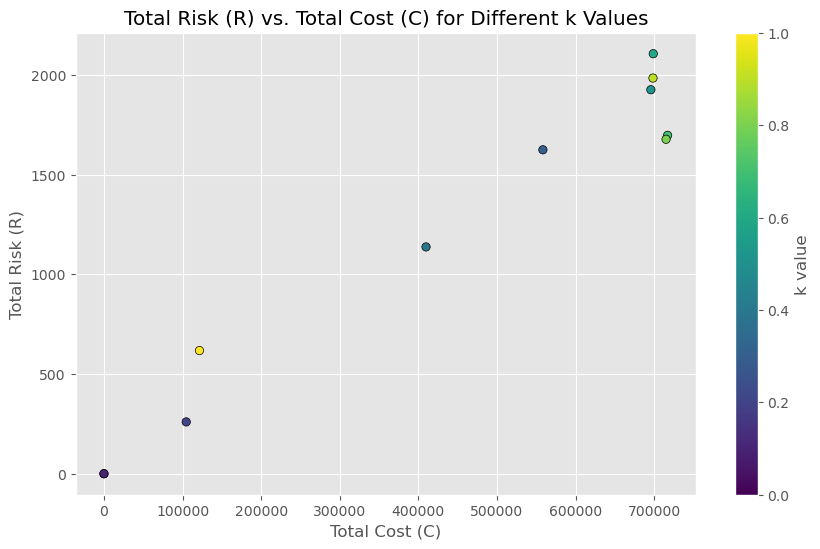

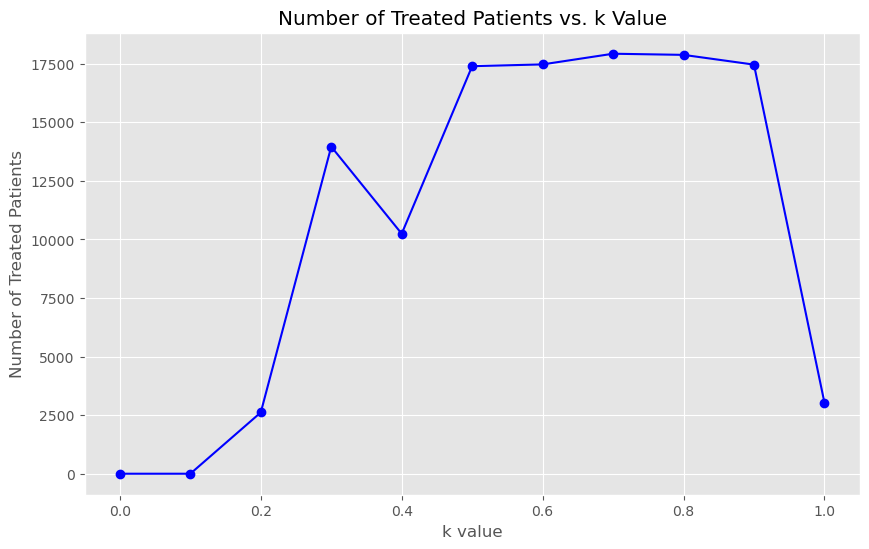

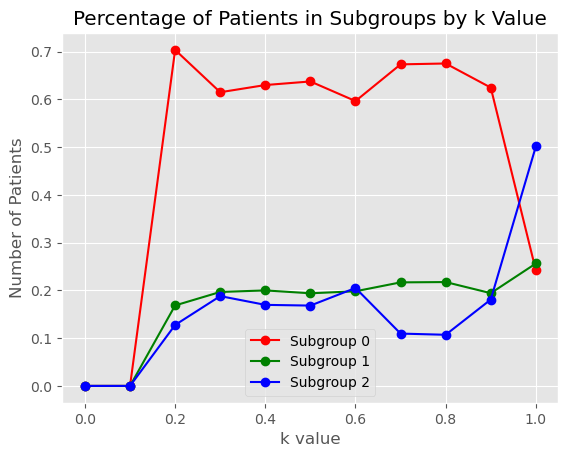

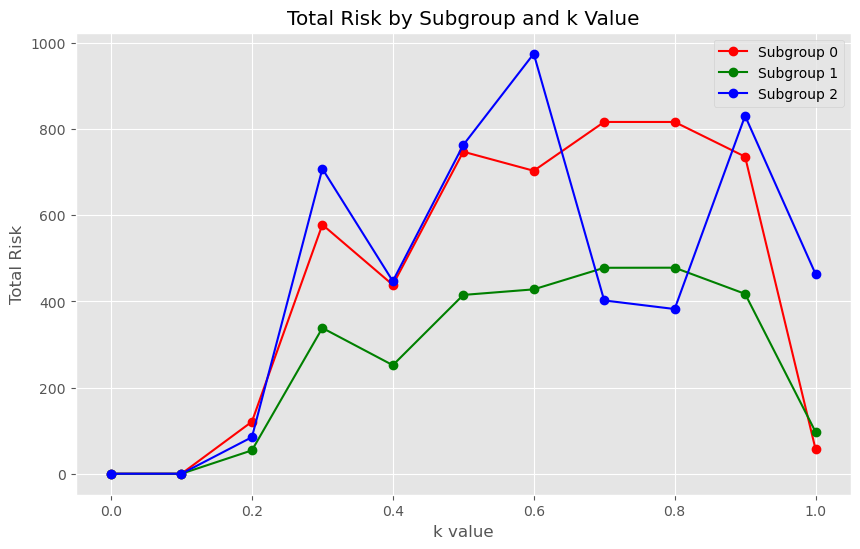

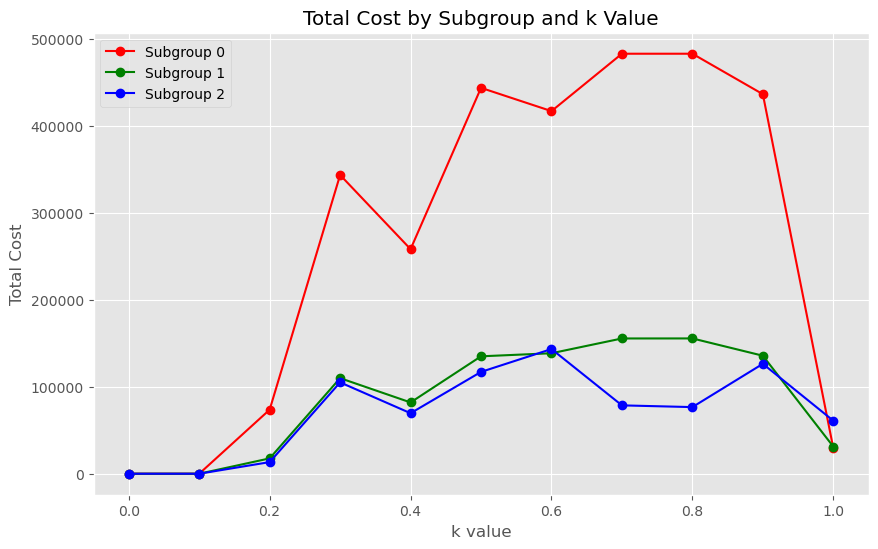

In [22]:
mdls.plot_R_vs_C_with_treatment(results_df)

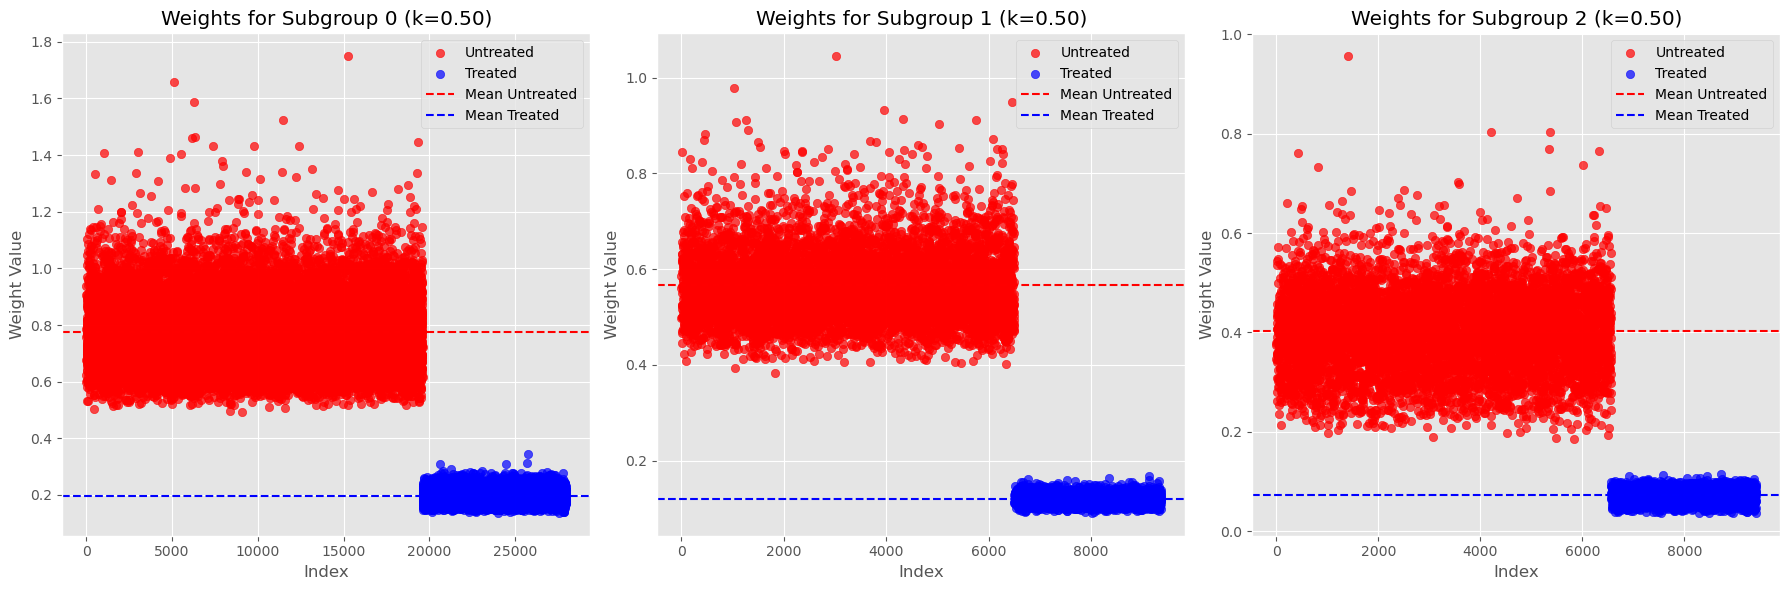

In [23]:
def plot_individual_weights_by_subgroup(train_df, risk_col, cost_col, tx_col, k_value):
    subgroups = [0, 1, 2]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, subgroup in enumerate(subgroups):
        subgroup_df = train_df[train_df['subgroup'] == subgroup]
        weights = []
        tx_labels = []
        
        for _, row in subgroup_df.iterrows():
            weight = (1 / (row[risk_col] ** k_value)) * (1 / (row[cost_col] ** (1 - k_value)))
            weights.append(weight)
            tx_labels.append(row[tx_col])
        
        ax = axes[i]
        
        # Separate treated and untreated
        treated_weights = [w for w, t in zip(weights, tx_labels) if t == 1]
        untreated_weights = [w for w, t in zip(weights, tx_labels) if t == 0]
        
        # Plot treated and untreated separately
        ax.scatter(range(len(untreated_weights)), untreated_weights, c='red', alpha=0.7, label='Untreated')
        ax.scatter(range(len(untreated_weights), len(weights)), treated_weights, c='blue', alpha=0.7, label='Treated')
        
        # Add mean lines
        ax.axhline(y=np.mean(untreated_weights), color='red', linestyle='--', label='Mean Untreated')
        ax.axhline(y=np.mean(treated_weights), color='blue', linestyle='--', label='Mean Treated')
        
        ax.set_xlabel('Index')
        ax.set_ylabel('Weight Value')
        ax.set_title(f'Weights for Subgroup {subgroup} (k={k_value:.2f})')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage
k_value = 0.5
plot_individual_weights_by_subgroup(train_df, 'risk', 'cost', 'Tx', k_value)


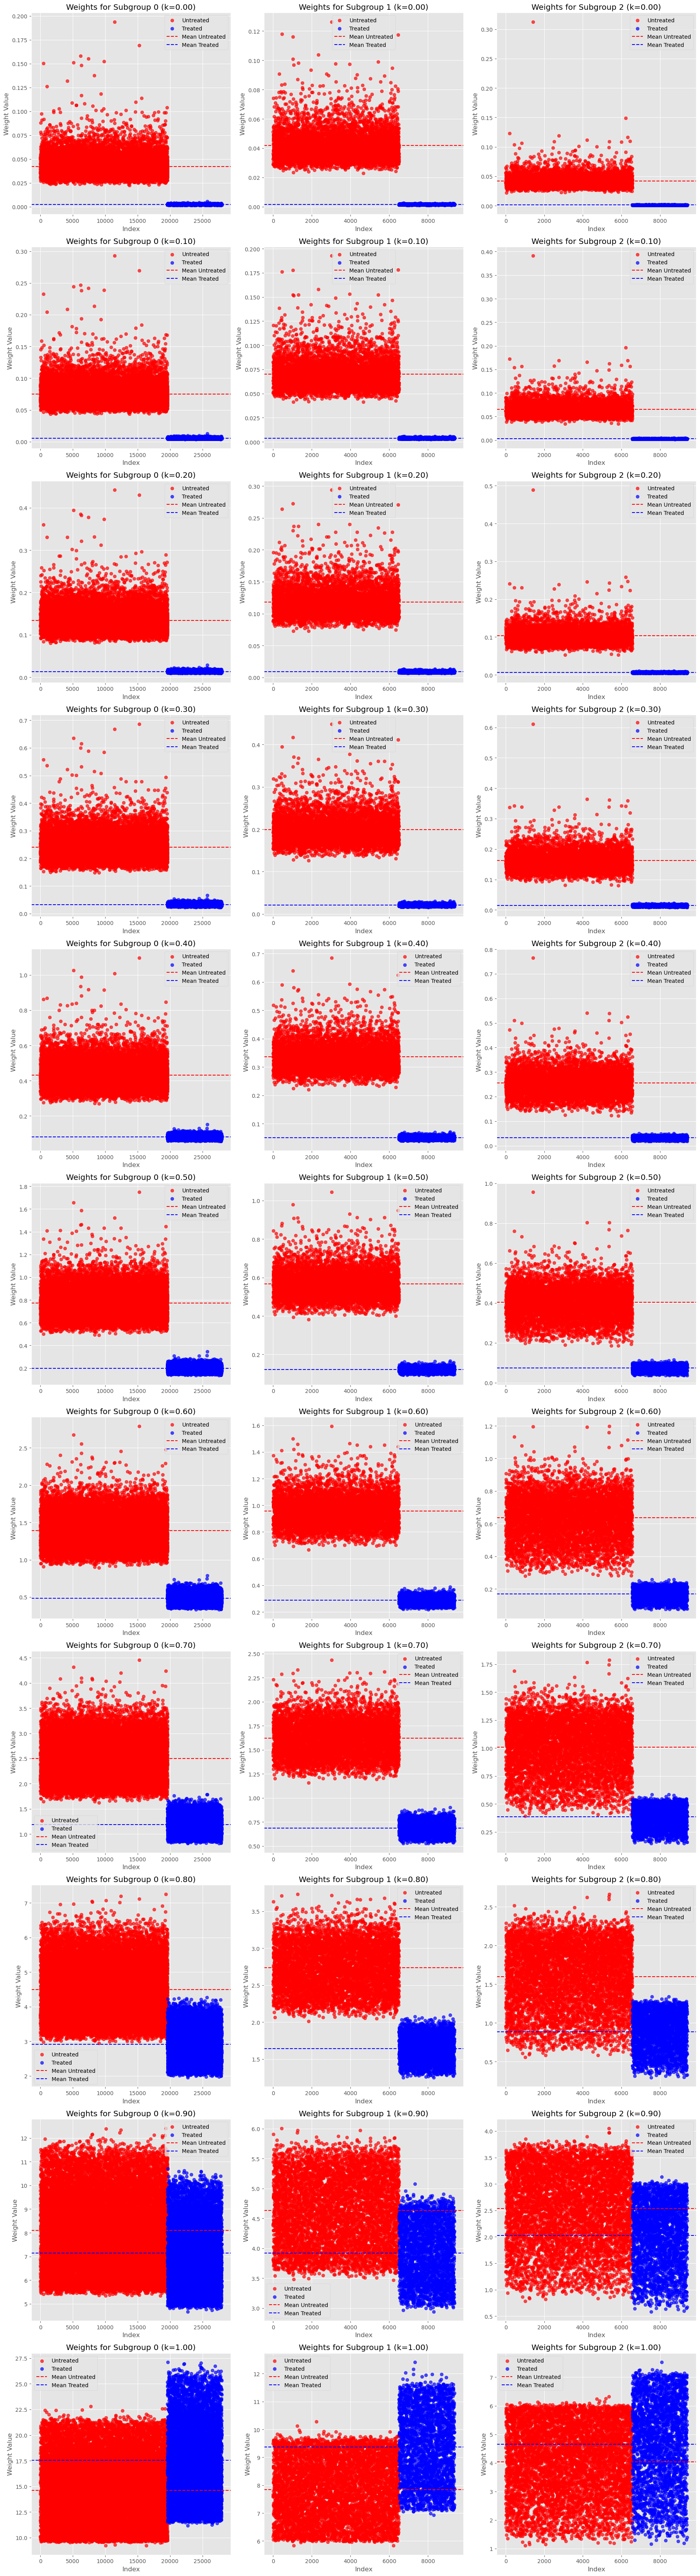

In [24]:
def plot_individual_weights_by_subgroup(train_df, risk_col, cost_col, tx_col, k_values):
    subgroups = [0, 1, 2]
    
    num_k = len(k_values)
    fig, axes = plt.subplots(num_k, 3, figsize=(18, 6*num_k))
    
    for k_idx, k_value in enumerate(k_values):
        for i, subgroup in enumerate(subgroups):
            subgroup_df = train_df[train_df['subgroup'] == subgroup]
            weights = []
            tx_labels = []
            
            for _, row in subgroup_df.iterrows():
                weight = (1 / (row[risk_col] ** k_value)) * (1 / (row[cost_col] ** (1 - k_value)))
                weights.append(weight)
                tx_labels.append(row[tx_col])
            
            ax = axes[k_idx, i]
            
            # Separate treated and untreated
            treated_weights = [w for w, t in zip(weights, tx_labels) if t == 1]
            untreated_weights = [w for w, t in zip(weights, tx_labels) if t == 0]
            
            # Plot treated and untreated separately
            ax.scatter(range(len(untreated_weights)), untreated_weights, c='red', alpha=0.7, label='Untreated')
            ax.scatter(range(len(untreated_weights), len(weights)), treated_weights, c='blue', alpha=0.7, label='Treated')
            
            # Add mean lines
            ax.axhline(y=np.mean(untreated_weights), color='red', linestyle='--', label='Mean Untreated')
            ax.axhline(y=np.mean(treated_weights), color='blue', linestyle='--', label='Mean Treated')
            
            ax.set_xlabel('Index')
            ax.set_ylabel('Weight Value')
            ax.set_title(f'Weights for Subgroup {subgroup} (k={k_value:.2f})')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Usage
k_values = [round(k, 1) for k in np.arange(0, 1.1, 0.1)]
plot_individual_weights_by_subgroup(train_df, 'risk', 'cost', 'Tx', k_values)